# Memory

- LLMs are often used for conversations.
- A fundamental component of a conversation is the ability to refer previous parts of the conversation exchange.
- But LLMs are stateless! 
- Idea: provide to the model a prompt which is the new input + a "memory" of the previous parts of conversation exchange.
- There are many ways to do this.
  - **Buffer Memory, Window Buffer Memory, ...** — Pass  (part of) the previous conversation _as is_ to the next input
  - **Summary Memory, Knowledge Graph Memory, ...** — Pass a summary of the previous conversation to the next input

In [1]:
import os
from pprint import pprint
from dotenv import load_dotenv

In [2]:
# 1. Copy .env.example file as .env: `cp .env.example .env`
# 2. Open .env file and set all the env variables
load_dotenv(".env")
OPENAI_KEY = os.getenv("OPENAI_KEY")
assert OPENAI_KEY, "Please set your OPENAI_KEY environment variable."

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationTokenBufferMemory
from langchain.memory import ConversationBufferWindowMemory
from langchain.memory import ConversationSummaryMemory
from langchain.memory import ConversationKGMemory

In [4]:
# The Chat Model
chat_model = ChatOpenAI(
    openai_api_key=OPENAI_KEY,
    model_name="gpt-4",
    temperature=1,
    model_kwargs={"top_p":1},
)

In [5]:
my_prompt_1 = "Hi! I live in Geneva. Do you know in which country it is?"
response_1 = chat_model.predict(my_prompt_1)
print("# Response 1:")
print(response_1, "\n")

my_prompt_2 = "OK, great, and can you suggest me a museum near home?"
response_2 = chat_model.predict(my_prompt_2)
print("# Response 2:")
print(response_2)

# Response 1:
Yes, Geneva is in Switzerland. 

# Response 2:
I'm an artificial intelligence and currently don't have access to personal data about individuals unless it has been shared with me in the course of our conversation. I'm designed to respect user privacy and confidentiality. Therefore, I don't know where your home is located. However, if you tell me your city, I can certainly help suggest some museums for you to visit there.


## Buffer Memory

This is the simplest memory, it just stores the last messages of the conversation.

In [6]:
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

In [7]:
response_1 = conversation.predict(input=my_prompt_1)
print("RESPONSE:", response_1, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi! I live in Geneva. Do you know in which country it is?
AI:

> Finished chain.
RESPONSE: Hello! Yes, I do. Geneva is located in Switzerland. It's known for its diplomatic and international significance, hosting the headquarters of many agencies of the United Nations and the Red Cross. 



In [8]:
print(memory.buffer)

Human: Hi! I live in Geneva. Do you know in which country it is?
AI: Hello! Yes, I do. Geneva is located in Switzerland. It's known for its diplomatic and international significance, hosting the headquarters of many agencies of the United Nations and the Red Cross.


In [9]:
response_2 = conversation.predict(input=my_prompt_2)
print("RESPONSE:", response_2, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi! I live in Geneva. Do you know in which country it is?
AI: Hello! Yes, I do. Geneva is located in Switzerland. It's known for its diplomatic and international significance, hosting the headquarters of many agencies of the United Nations and the Red Cross.
Human: OK, great, and can you suggest me a museum near home?
AI:

> Finished chain.
RESPONSE: Sure! You might want to visit the Patek Philippe Museum. It's in the middle of Geneva and hosts an extraordinary collection of watches, including antique pieces and related artifacts. It's a great place to discover the history of watchmaking, a significant industry in Switzerland. 



## Window Buffer Memory

- Same principle as Buffer Memory, but it stores the last messages of the conversation in a window of fixed size.
- Two different classes implementing this approach:
  - `ConversationBufferWindowMemory` — store `k` last messages
  - `ConversationTokenBufferMemory` — store `max_token_limit` last tokens

In [10]:
memory = ConversationBufferWindowMemory(k=5)
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

## Summary Memory

- Here the idea is to pass to the model as new prompt the new input plus a summary of the conversation so far.
- And how do we generate the summary? With a LLM, of course!
- Therefore, we need to pass in the constructor of the Memory object a LLM that will be used to generate the summary.

In [11]:
memory = ConversationSummaryMemory(llm=chat_model)
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

In [12]:
response_1 = conversation.predict(input=my_prompt_1)
print("RESPONSE:", response_1, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi! I live in Geneva. Do you know in which country it is?
AI:

> Finished chain.
RESPONSE: Hello! Yes, Geneva is located in Switzerland. It's quite known for its diplomatic and international significance, being home to many worldwide organizations like the Red Cross and numerous United Nations agencies. 



In [13]:
print(memory.buffer)

The human, who lives in Geneva, asks the AI if it knows in which country Geneva is located. The AI confirms that Geneva is in Switzerland, known for its international significance and housing organizations like the Red Cross and various United Nations agencies.


In [14]:
response_2 = conversation.predict(input=my_prompt_2)
print("RESPONSE:", response_2, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
The human, who lives in Geneva, asks the AI if it knows in which country Geneva is located. The AI confirms that Geneva is in Switzerland, known for its international significance and housing organizations like the Red Cross and various United Nations agencies.
Human: OK, great, and can you suggest me a museum near home?
AI:

> Finished chain.
RESPONSE: Of course, I would suggest the Patek Philippe Museum, located in Plainpalais, Geneva. This museum showcases timepieces dating from the 16th century to the present. It includes a collection of the most prestigious creations of the brand, as well as a significant ensemble of antique horological pieces. It's a unique oppor

## Knowledge Graph Memory

- Information about the previous conversation can be summarized as a string.
- But this is not the only option. For instance, we can decide to summarize the previous conversation as a knowledge graph.

In [15]:
memory = ConversationKGMemory(llm=chat_model)

In [16]:
text = """
Aspirin causes several different effects in the body, mainly the reduction of inflammation, analgesia
(relief of pain), the prevention of clotting, and the reduction of fever. Much of this is believed
to be due to decreased production of prostaglandins and TXA2. Aspirin's ability to suppress the
production of prostaglandins and thromboxanes is due to its irreversible inactivation of the
cyclooxygenase (COX) enzyme.
"""

# Save context from this conversation to buffer. This will update the internal KG memory.
memory.save_context({"input": text}, {"output": ""})

In [17]:
print(type(memory.kg._graph))
print(memory.kg._graph)

<class 'networkx.classes.digraph.DiGraph'>
DiGraph with 9 nodes and 8 edges


In [18]:
my_graph = memory.kg._graph

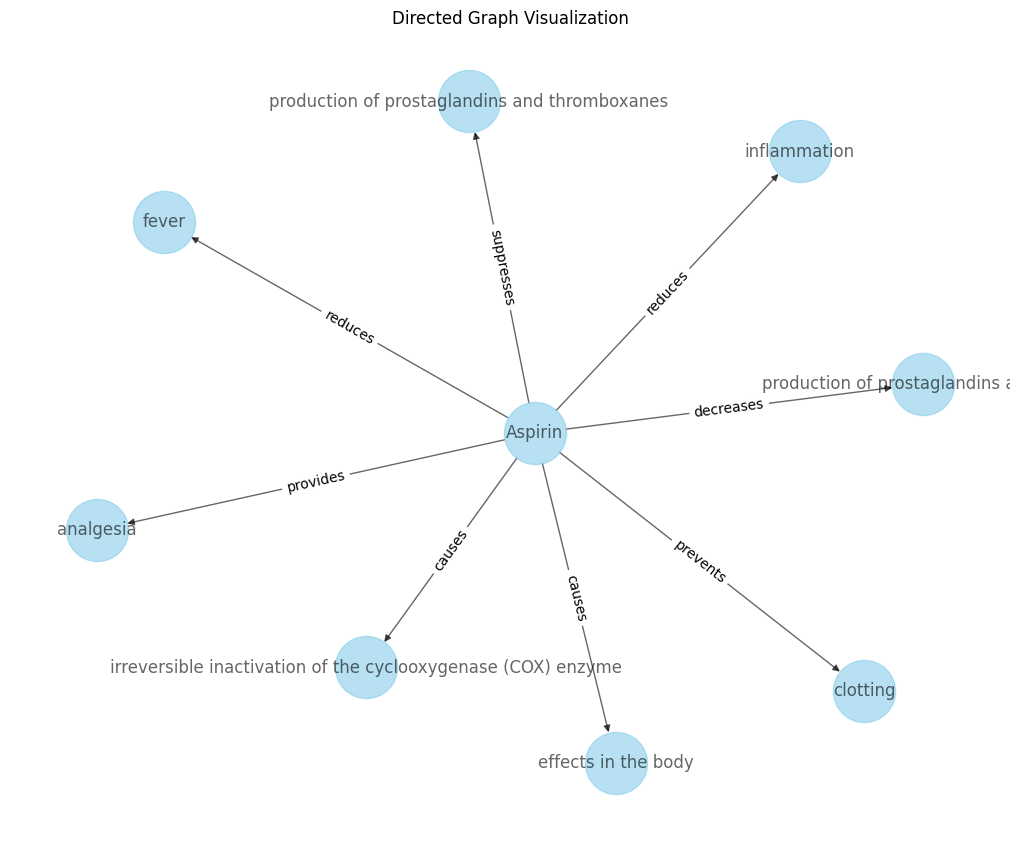

In [19]:

# Draw the graph
plt.figure(figsize=(10,8))
pos = nx.spring_layout(my_graph)  # Positioning of nodes
nx.draw(my_graph, pos, with_labels=True, node_size=2000, node_color="skyblue", node_shape="o", alpha=0.6, linewidths=1)

# Extract relation attributes for edge labels
edge_labels = {(u, v): my_graph[u][v]['relation'] for u, v in my_graph.edges()}

nx.draw_networkx_edge_labels(my_graph, pos, edge_labels=edge_labels, label_pos=0.5)
plt.title("Directed Graph Visualization")
plt.show()
